# LINMA2472 - Project 1 (Network)
#### Student : Thonnard Julien - Van Droogenbroeck Elise - Vermeulen Corentin 

#### Packages import

In [1]:
#!pip install networkx
#!pip install python-louvain

import community
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import operator
import pandas as pd
import re
import sklearn.cluster
import time

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Co-occurrence network of characters

#### Text pre-processing

In [2]:
file1_loc = "HarryPotterChamberOfSecrets.txt"
text1_brut = []  
with open(file1_loc, "r") as f:
    for line in f:
        line = line.replace("/", " \ne ")
        line = line.strip()
        if line != '' and line != '\n':
            text1_brut.append(line)

CharScene = []  
for line in text1_brut:
    line = re.sub("([0-9])+([A-Z])?", "", line)
    line = line.strip()
    if "INT." in line or "EXT." in line:
        line = "SCENE"
    line = line.replace("CONTINUED", "")
    line = line.replace("OMITTED", "")
    line = line.replace("(CONT'D)", "")
    line = line.replace(" (O.S.)", "  ")
    line = line.replace("JUSTIN-FINCH-FLETCHLEY", "JUSTIN FINCH-FLETCHLEY")
    line = line.replace("DUMBLEDORE", "ALBUS DUMBLEDORE")
    line = line.replace("LUCIOUS MALFOY", "LUCIUS MALFOY")
    line = line.replace("TOM", "TOM RIDDLE")
    line = line.replace("RIDDLE", "TOM RIDDLE")
    line = line.replace("!", "")
    if (":") in line or (".") in line or ('(') in line:
        line = ""
    elif line.isupper() and len(line) > 2:
        CharScene.append(line.strip())

errors = ["THUD", "UP", "LEAVE HIM", "THE END", "WATCH OUT", "STOP", "HOME", "FLASH", "TURN", "THE WINDOWS"]

CharScene_clean = []
for i in CharScene:
    if i not in errors:
        CharScene_clean.append(i)

characters1 = []
vector = []
for i in CharScene_clean:
    if len(i.split()) <= 2 and i != "SCENE":
        characters1.append(i)
        vector.append(i)
    if i == "SCENE":
        vector.append(i)

all_char = []
scene_char = []
for i in range(len(vector)):
    if vector[i] == "SCENE":
        scene_char = []
        all_char.append(scene_char)

    else:
        scene_char.append(vector[i])
all_char.append(scene_char)

#print(all_char)

#### Co-occurence matrix

In [3]:
all_char_set = []
for i in range(len(all_char)):
    if all_char[i] == []:
        pass
    else:
        all_char_set.append(list(set(all_char[i])))

#print(all_char_set)
sorted_char = sorted(list(set(characters1)))

df = pd.DataFrame(np.zeros((len(sorted_char), len(sorted_char))), columns=sorted_char, index=sorted_char)

for sc in all_char:  
    if len(sc) < 2:
        pass
    for i in range(len(sc) - 1):
        for j in range(1, len(sc)):
            a = sorted_char.index(sc[i])
            b = sorted_char.index(sc[j])
            df.iloc[a, b] += 1
            df.iloc[b, a] += 1

node_size = []
for i in range(len(df)):
    # df.iloc[i,i]= vector.count(sorted_char[i])
    df.iloc[i, i] = 0
    node_size.append(vector.count(sorted_char[i]))

df.head()

,AGED WITCH,ALBUS DUMBLEDORE,ARAGOG,AUNT PETUNIA,COLIN,DEAN THOMAS,DOBBY,DRACO,DUDLEY,ERNIE,...,SEAMUS,SHORT MAN,SNAPE,SORTING HAT,SQUAWK,TOM RIDDLE,UNCLE VERNON,VOICE,WOOD,YOUNG HAGRID
AGED WITCH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALBUS DUMBLEDORE,0.0,0.0,0.0,0.0,0.0,0.0,45.0,11.0,0.0,0.0,...,0.0,0.0,49.0,15.0,0.0,0.0,0.0,9.0,0.0,0.0
ARAGOG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AUNT PETUNIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
COLIN,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0


## Analysing the communities of the graph

#### Network Visualisation

Our final graph is composed of 42 nodes and 179 edges. 

We clearly see that the main characters of the movie have the most edges. It seems that our network is a good representation of the interactions between the characters in the movie. We may suppose that one of the communities will be composed of all the main characters like Harry, Hermione, Ron, etc. The different teachers may also form their own community among themselves. Finally, two characters (Ernie and Hannah) only interact with each other so they will form their own community too. This will have an impact on the following results.

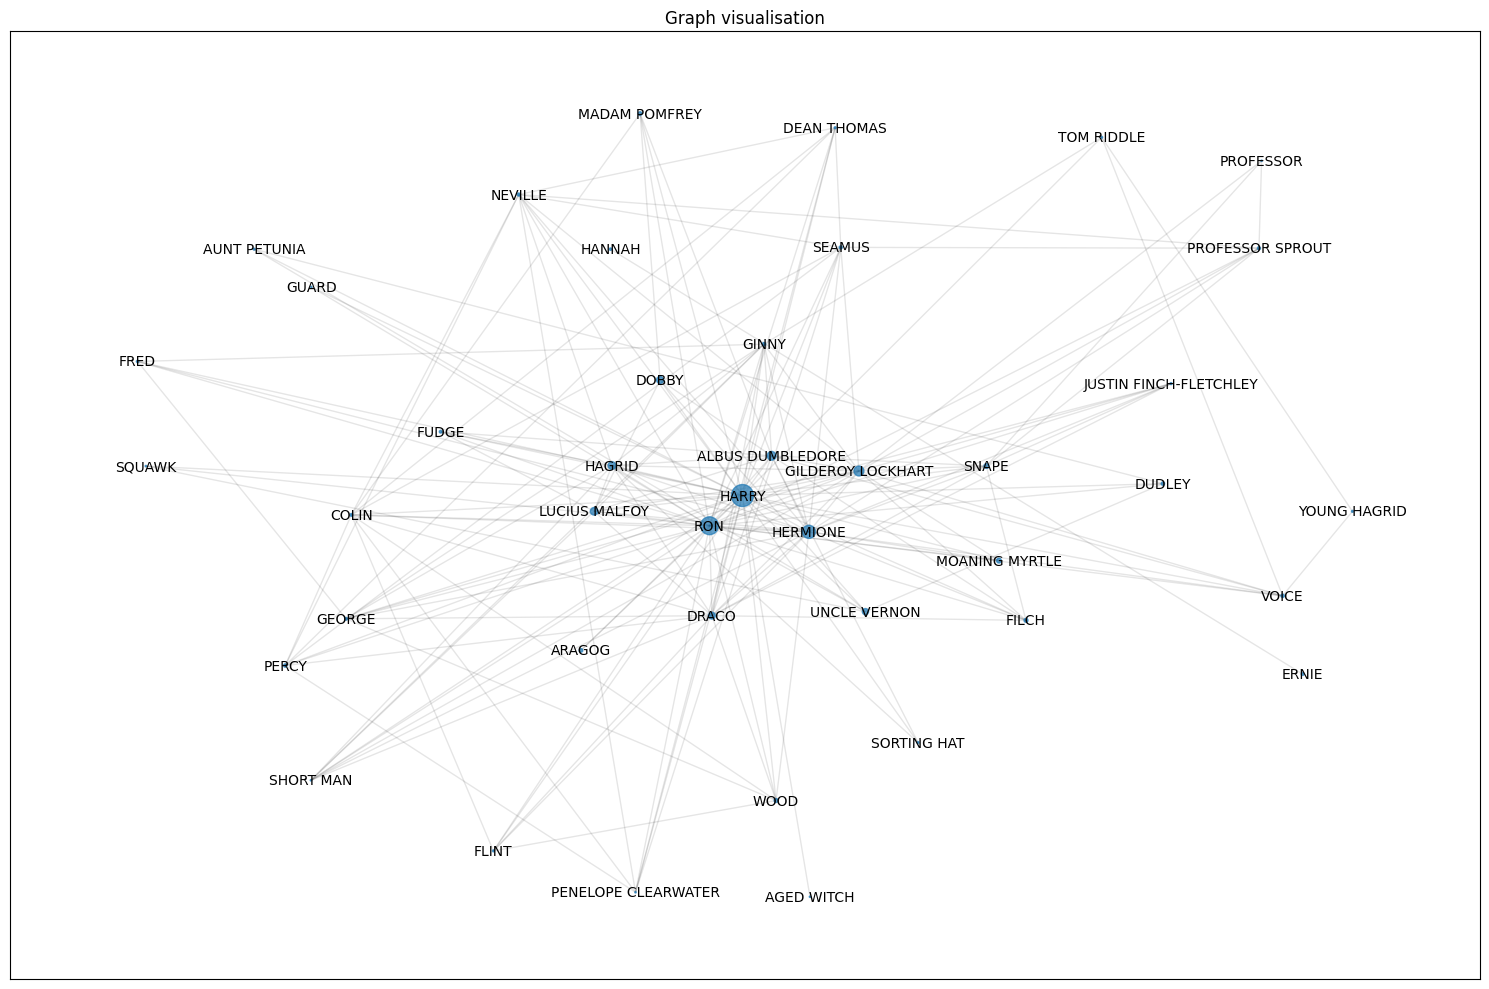

In [4]:
G = nx.from_pandas_adjacency(df)

fgz = (15, 10)
pos = nx.spring_layout(G, seed=2, k=3)
plt.figure(figsize=fgz)
weight_of_edges = list(nx.get_edge_attributes(G, "weight").values())
nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Graph visualisation")
plt.tight_layout()
plt.show()

#### Degree assortativity of the network

A negative degree assortativity coefficient implies relationships between nodes of different degree (graphically, nodes with many links are connected to nodes with few links) while a positive coefficient means that nodes tend to connect to similar degree nodes. 

In the case of a movie, it is relevant to see a negative coefficient since the main characters are in general connected to all the other characters, independently of their degree. 

In [5]:
degree = nx.degree_assortativity_coefficient(G)
print("Degree of assortativity: ", round(degree, 3))

Degree of assortativity:  -0.346


#### Louvain algorithm

The communities are consistent with the story. The first and biggest cluster is composed of the main characters of the story (Harry, Ron, Hermione, Aragog, etc.). The second biggest cluster contains the secondary characters, such as Draco, Colin, etc. The other communities are composed of the less important characters of the story, such as the green community with Harry's in-laws.
As mentioned above, Hannah and Ernie form a separate community because they only interact with each other.

/Users/corentinvermeulen/opt/miniconda3/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


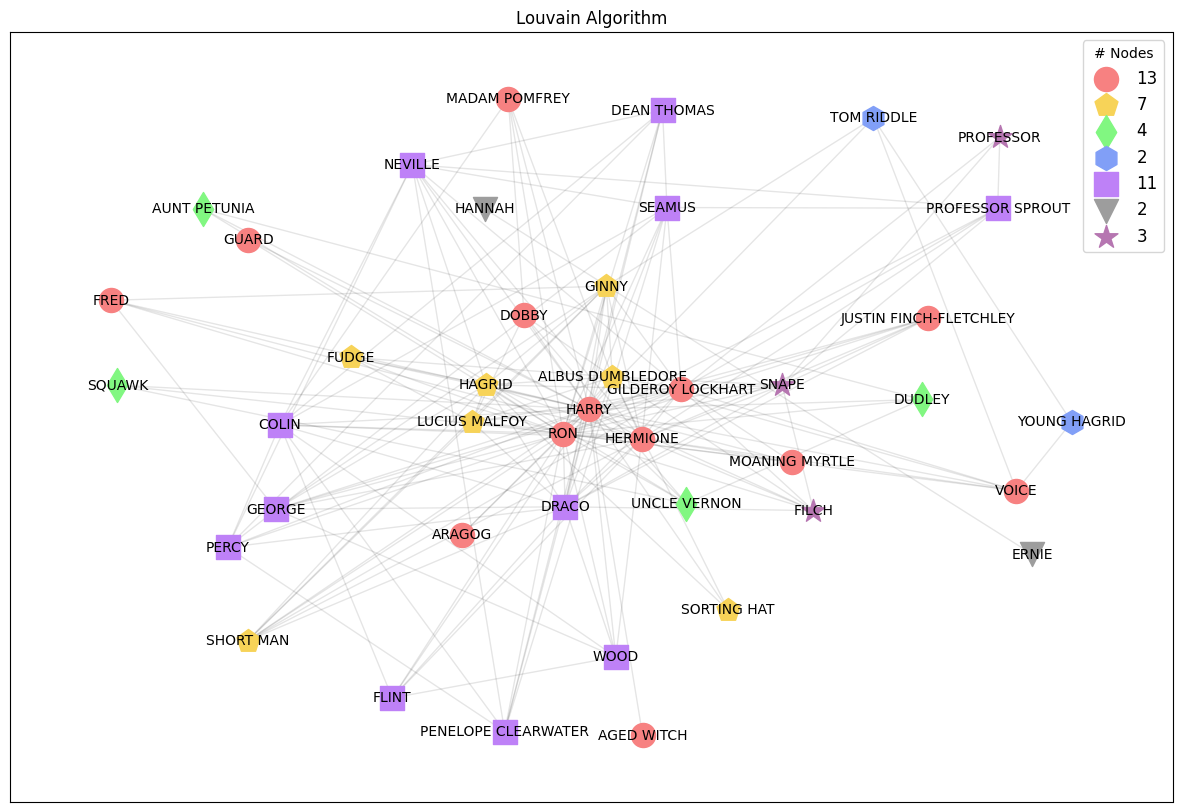

In [6]:
partition = community.best_partition(G, randomize=False)  # Dictionnaire
n_indiv = len(partition)  
communities_colors = ["#F78181", "#F7D358", "#81F781", "#819FF7", "#BE81F7", "#9D9D9D", "#B676B1"  ]
communities_shape = "opdhsv*>"
# Draw graph with partition
plt.figure(figsize=fgz)
for i in range(max(partition.values()) + 1):
    individus = 0 
    node_list = [] 
    for char, commu in partition.items():
        if commu == i:
            individus += 1
            node_list.append(char)
    nx.draw_networkx_nodes(G, pos, nodelist=node_list,
                           cmap=plt.get_cmap('rainbow'),
                           label=individus,
                           node_color=communities_colors[i],
                           node_shape=communities_shape[i])
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.legend(title="# Nodes", prop={'size': 12})
plt.title("Louvain Algorithm")
plt.show()

#### Spectral clustering on the Laplacian

The ```nx.spectracl_layout()``` function doesn't give exploitable results since most of the points are gathered on the same spot and only one other point is on a different axis. This single point represents Hannah and Ernie since they are not linked to the rest of the graph. Better results could be obtained if Ernie and Hannah were removed from the characters. 
Therefore we decided to visualise the spectral clusters using a K-means on the spectral coordinates. 
As expected, most of the points are purple and are gathered in the top right corner. Hannah and Ernie are located in the same cluster which is logical since they are only linked to each other. The other clusters are only composed of one individual with a low degree. 

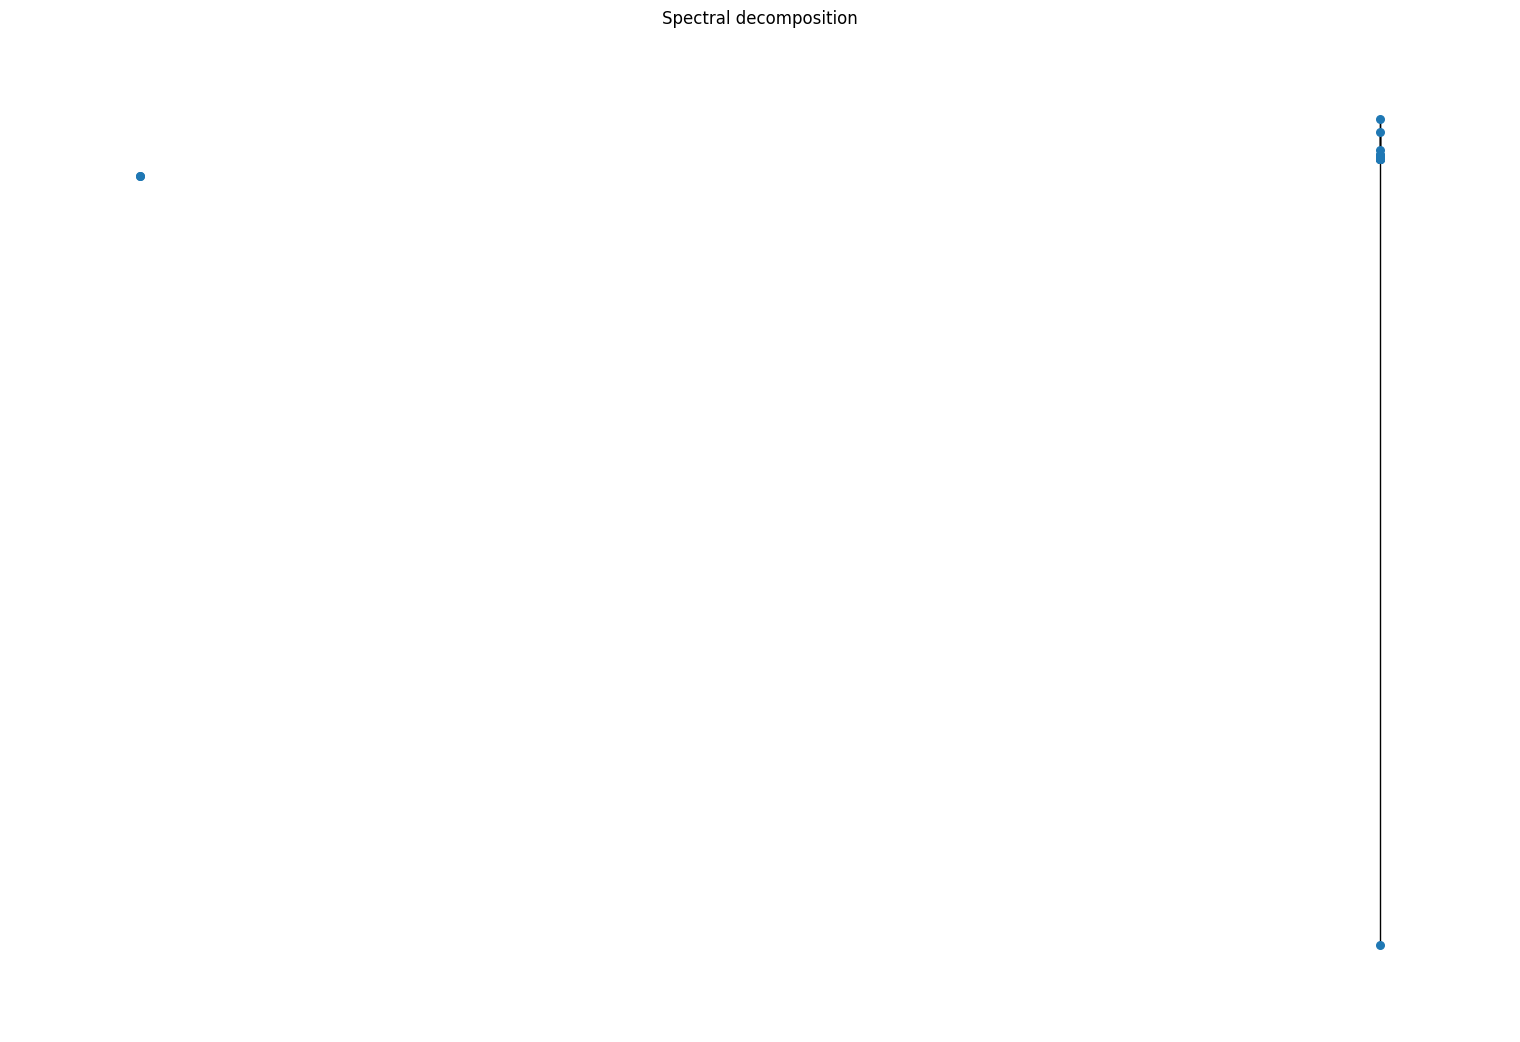

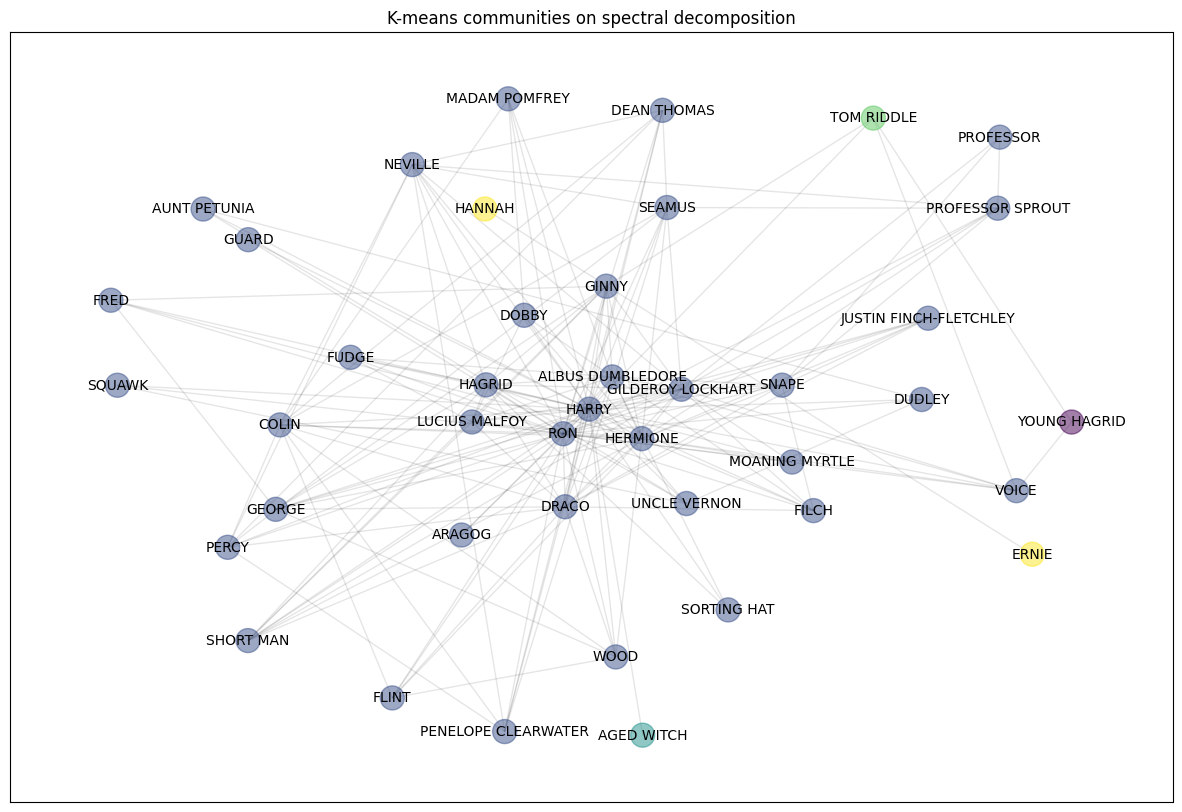

In [7]:
plt.figure(figsize=fgz)
nx.draw_spectral(G, with_labels=False,node_size=30)
plt.title("Spectral decomposition")
plt.show()

plt.figure(figsize=fgz)
spectral_coords = nx.spectral_layout(G, dim=3)
partitions = sklearn.cluster.KMeans(n_clusters=5).fit_predict([spectral_coords[node] for node in G.nodes()])
nx.draw_networkx_nodes(G, pos, node_color = partitions, alpha=0.5)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("K-means communities on spectral decomposition")
plt.show()

#### Comparaison between Louvain Algorithm and the spectral decomposition on the Laplacian

The spectral decomposition doesn't return good results because there are only a few communities. It is coherent since when we give a first glance at the network visualisation no community really stands out. 
When we take the story into account the louvain algorithm is more consistent, as said before it really fits the character's hierarchy.

## Maximising the influence in the graph

#### Definition of the ICM 

The `ICM()` function returns the average number of reached nodes of graph `G` when starting from a seed set `A0` and where the probability of reaching a non-reached node is `p`. 

In [8]:
def ICM(Gi,A0, p=0.25, n_iter=50, plot=False):
    np.random.seed(3)
    res = []
    x = [] 
    y = [] 
    for i in range(n_iter):
        n_infected = [len(A0)]
        G = Gi.copy()
        cascade = [A0]
        observation = A0.copy()

        t = 0
        x.append(t);
        y.append(len(A0))  # Point de départ
        while len(observation) > 0:
            for infected in observation:
                period= []
                lost_edges = []
                for attempt in G.neighbors(infected):
                    if any(attempt in sublist for sublist in cascade):
                        pass
                    else:
                        if np.random.random(1)[0] < p:
                            period.append(attempt)
                            observation.append(attempt)
                        else:
                            lost_edges.append(attempt)
                for i in lost_edges:
                    G.remove_edge(i, infected)
                if period != [] :cascade.append(period)
                n_infected.append(len(period))
                x.append(t)
                t+=1
                y.append(sum(n_infected))
                observation.remove(infected)
        res.append(sum(n_infected))
    if plot:
        y = (np.array(y)/42)*100
        x = np.array(x)
        p2 = np.poly1d(np.polyfit(x, y, 4))
        xp = np.linspace(min(x), max(x), 100)
        plt.plot(xp, p2(xp), c='r')
        plt.scatter(x, y, alpha=0.1, s=5)
        plt.xlabel('time')
        plt.ylabel('Proportion of reached poeple [%]')
        plt.title('Spreading curve when strating with A0={0}\n Max reached proportion:{1} %'.format(A0, round(max(y), 3)))
        plt.show()

    return np.mean(res)

#### Greedy algorithm

The `greedy_algorithm()` function returns the set of nodes that will maximize the mean reached people with the `ICM()` function starting from that set of nodes as seed.

Afer computing the greedy algorithm on our graph we find that the best seed set is composed of *Harry* and *Hannah*. *Harry* is the lead character, he has the highest degree thus he is the most likely to reach everybody. *Hannah* on its side is completely disconnected from the main graph. She's only connected to *Ernie*. 
Starting with *Harry* first allows us to reach almost the full graph and adding *Hannah* (or *Ernie*) allows us to reach two more people. 

In [9]:
def greedy_algorithm(Gi, k=0.05, p=0.25, n_iter=500, plot=False):
    A0 = []
    nA0 = int(len(Gi) * k)
    max_score_log = []  
    max_time_log = []  
    score_log = []  
    time_log = []  
    t0 = time.time()
    while len(A0) < nA0:
        max_score = 0
        max_node = ""
        for node in (set(Gi.nodes()) - set(A0)):
            node_set = A0 + [node]
            node_score = ICM(Gi, node_set, p, n_iter)
            if node_score > max_score:
                max_node = node
                max_score = node_score
            max_score_log.append(max_score)
            max_time_log.append(time.time() - t0)
            time_log.append(time.time() - t0)
            score_log.append(node_score)
        A0.append(max_node)
    max_score_log.append(max_score)
    max_time_log.append(time.time() - t0)

    if plot:
        plt.figure(figsize=fgz)
        plt.scatter(np.array(time_log), (np.array(score_log)/42)*100, alpha=0.3)
        plt.plot(np.array(max_time_log), (np.array(max_score_log)/42)*100, c='red', alpha=0.3)
        plt.xlabel('Time')
        plt.ylabel('Proportion of influenced nodes [%]'.format(len(Gi)))
        plt.title('Progression log [p = {0} ;k = {1} ; n_iter = {2}]\n MI nodes: {3}'.format(p, k, n_iter, A0))
        plt.show()

    return A0

In [10]:
MI = greedy_algorithm(G)
print("MI node set resulting from greedy algorithm: {0}".format(MI))

MI node set resulting from greedy algorithm: ['HARRY', 'HANNAH']


#### ICM on MI set compared to ICM on largest degree set

Choosing the two nodes with the higgest degree don't show us the best result compared to the choice made by the Greedy algorithm. Indeed, we say before that we have two characters disconnected from the others characters. Moreover, this two characters doesn't have a high degree so they won't be chosen as one of the two character with the highest degree. So, with the Greedy algorithm who choose one of this node, the model can influence more people. 

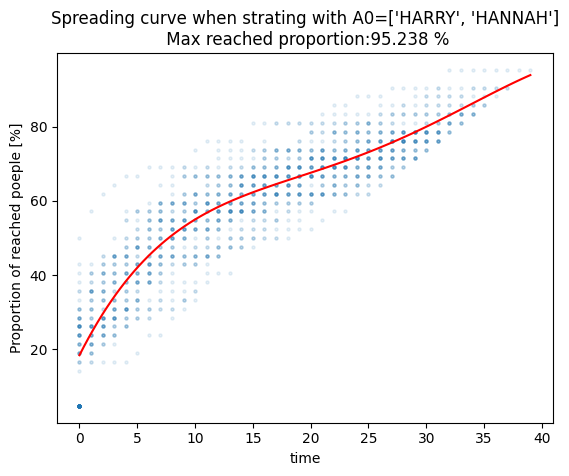

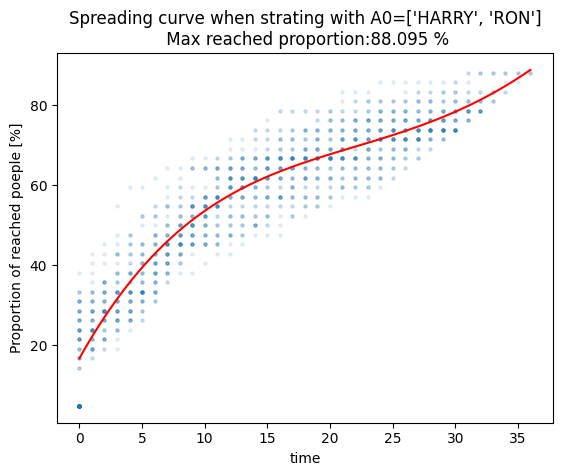

31.26

In [11]:
ICM(G, greedy_algorithm(G), plot=True)

A0 = list(np.array(sorted(G.degree, key=lambda x: x[1], reverse=True)[:2])[:,0])
ICM(G, A0, plot=True)

#### Barabasi-Albert network

We see that the degree assortivity of the Barabasi-Albert network is bigger than the degree assortivity of the network of our movie. It is normal because the Barabasi-Albert network is more homogeneous. That means that the links are better distributed between the nodes in the Barabasi-Albert network. With that principle, the percentage of influenced characters is bigger and the time needed too influenced those people is smaller on the Barabasi-Albert network. 

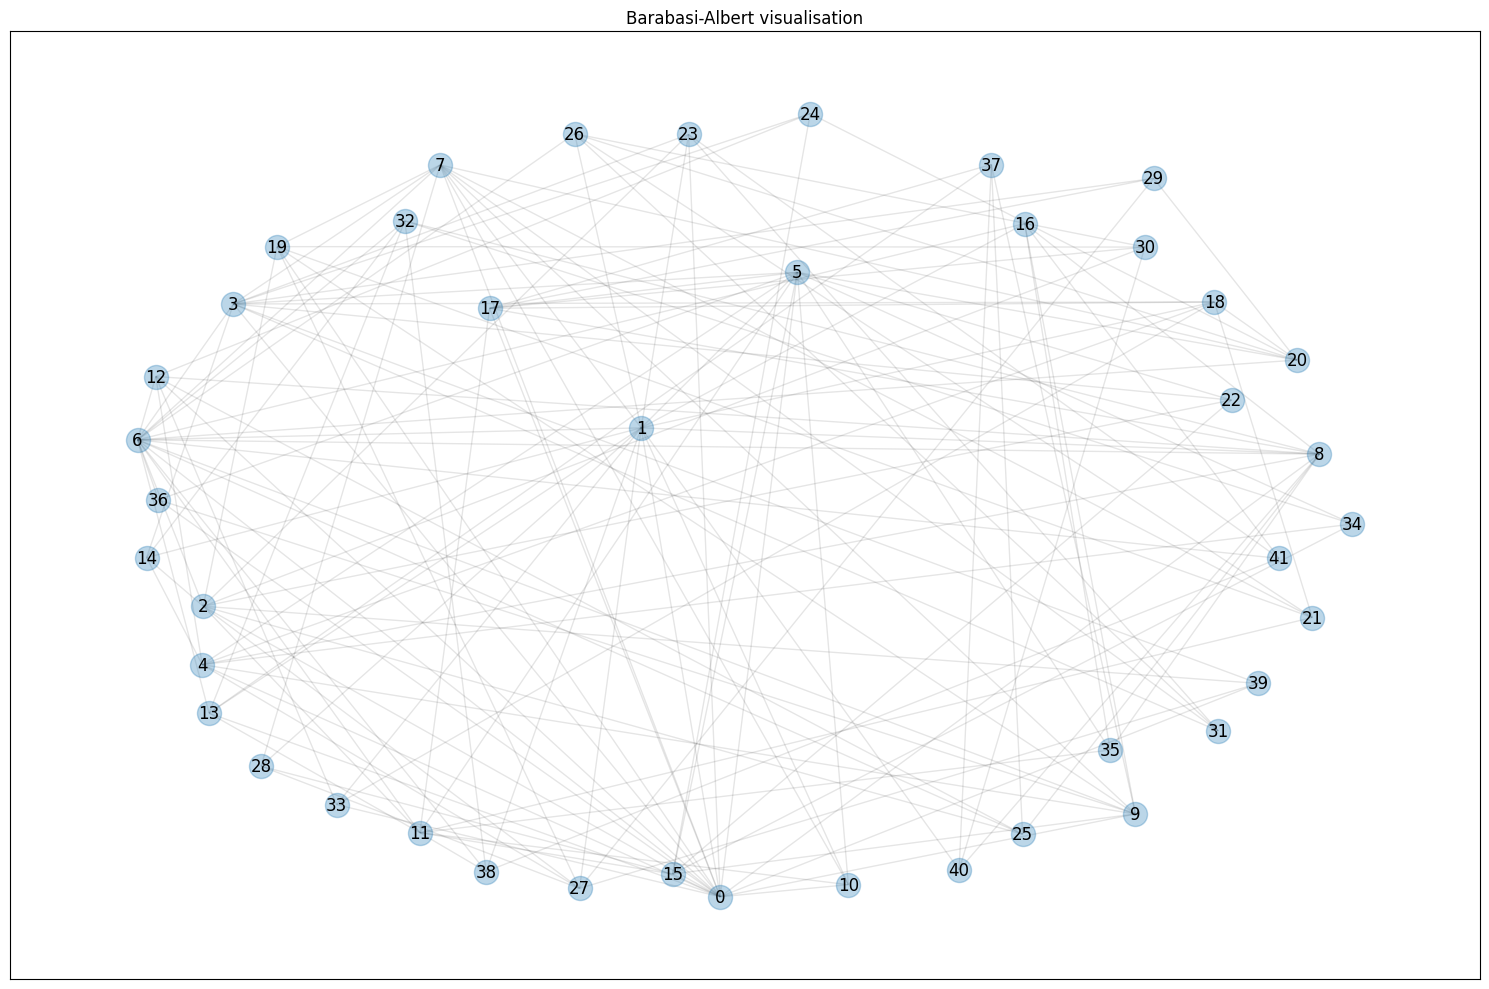


-0.11704713197250621


In [12]:
n = len(G.nodes())
m = G.number_of_edges()/n
B = nx.barabasi_albert_graph(n, int(m))

## Visualisation du barabasi network
pos = nx.spring_layout(B, seed=2, k=3)
plt.figure(figsize=fgz)
weight_of_edges = list(nx.get_edge_attributes(B, "weight").values())
nx.draw_networkx_nodes(B, pos, alpha=0.3)
nx.draw_networkx_edges(B, pos, alpha=0.1,)
nx.draw_networkx_labels(B, pos)
plt.title("Barabasi-Albert visualisation")
plt.tight_layout()
plt.show()
print()


print(nx.degree_assortativity_coefficient(B))

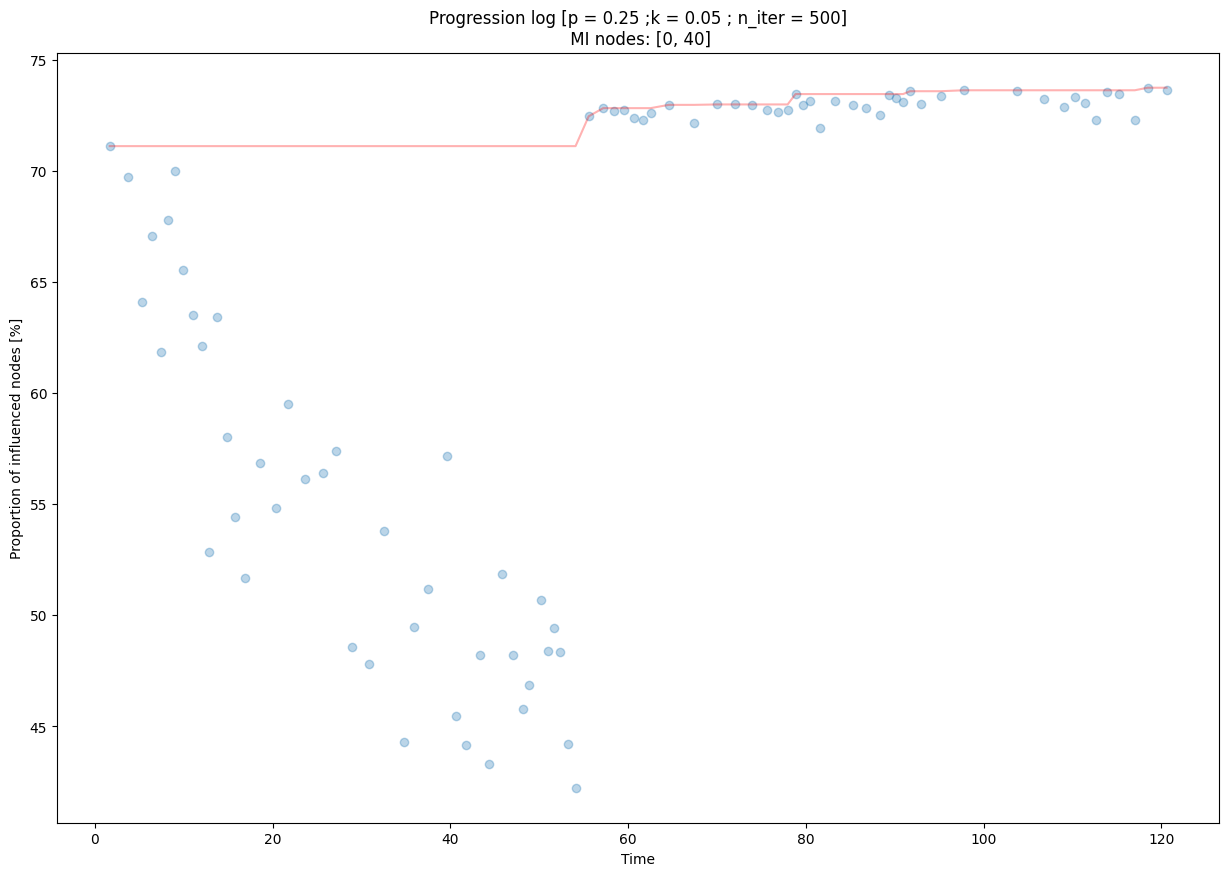

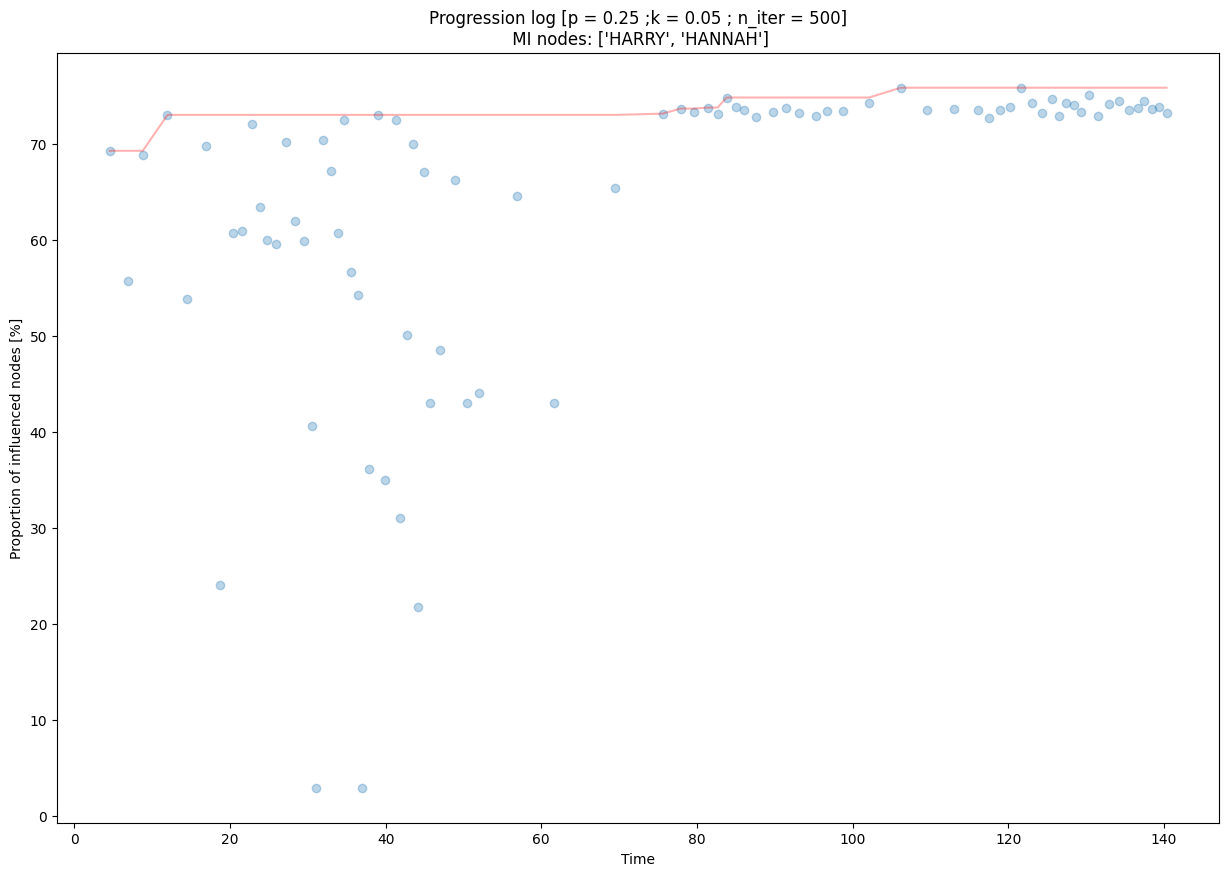

In [13]:
MI_barabasi = greedy_algorithm(B, plot=True)
MI = greedy_algorithm(G, plot=True)